In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def data_loading(train_batches, test_batches):
    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train = True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor()
                       ])),
        batches = train_batches, shuffle=True)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train = False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])),
        batches = test_batches, shuffle=True)

    return (train_loader, test_loader)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [5]:
def sensitivity(model):
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            fNormAll += fNorm
            counter += 1
    return fNormAll / counter

In [6]:
def define_opt(model, lr):
    return optim.SGD(model.parameters(), lr = lr, momentum=0.9, nesterov=True)

In [7]:
def train(model, opt, train_loader):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        opt.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()


In [8]:
def calculate_loss(model, loader, loss_fn):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data)
            cost = loss_fn(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
    return costTotal / costCounter, round(correct/total, 3)

In [9]:
def compute(model, opt):
    for epoch in range(1, epochs + 1):
        train(model, opt, train_loader)
        tr_loss, tr_acc = calculate_loss(model, train_loader, loss_fn)
        t_loss, t_acc = calculate_loss(model, test_loader, loss_fn)
    print("Model Train loss: ", tr_loss)
    loss_train_arr.append(tr_loss)
    loss_test_arr.append(t_loss)
    train_acc_arr.append(tr_acc)
    test_acc_arr.append(t_acc)
    print("Model Test loss: ", t_loss)

In [10]:
loss_train_arr = []
loss_test_arr = []
test_acc_arr = []
train_acc_arr = []
sensList= []
epochs = 30


In [13]:
batches = [100, 250, 500, 5000, 10000]
for batch in batches:
    torch.manual_seed(1)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_loader, test_loader = data_loading(batch, batch)
    model1 = CNN()
    lr=0.015
    opt = define_opt(model1, lr)
    compute(model1, opt)
    sensList.append(sensitivity(model1))

Model Train loss:  tensor(0.0003)
Model Test loss:  tensor(0.0495)
Model Train loss:  tensor(0.0042)
Model Test loss:  tensor(0.0478)
Model Train loss:  tensor(0.0087)
Model Test loss:  tensor(0.0409)
Model Train loss:  tensor(0.1026)
Model Test loss:  tensor(0.0913)
Model Train loss:  tensor(0.2379)
Model Test loss:  tensor(0.2176)


In [14]:
def clean_arr(arr):
    temp_1 = []
    for i in arr:
        temp_1.append(i.data.numpy().tolist())
    return temp_1

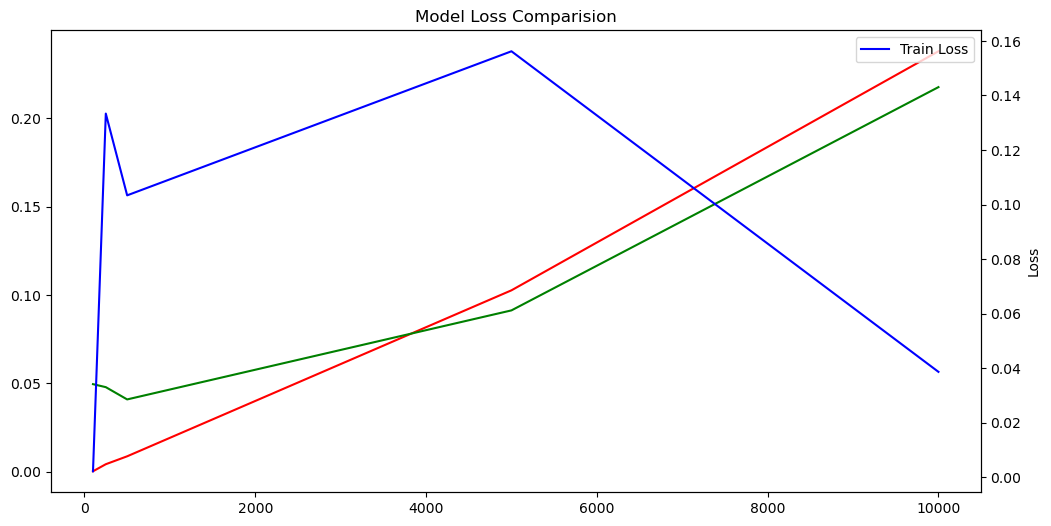

In [15]:
plt.figure(figsize=(12,6))
plt.plot(batches, loss_train_arr, color = "r")
plt.plot(batches, loss_test_arr, color = "g")
ax2 = plt.twinx()
plt.plot(batches, sensList, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


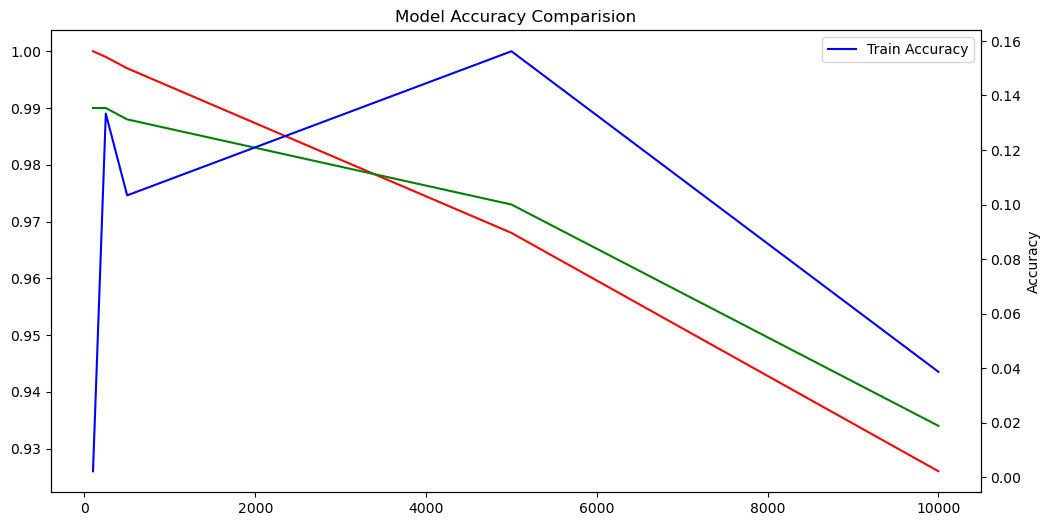

In [16]:
plt.figure(figsize=(12,6))
plt.plot(batches, train_acc_arr, color = "r")
plt.plot(batches, test_acc_arr, color = "g")
ax2 = plt.twinx()
plt.plot(batches, sensList, color = "b")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [17]:
sensList

[0.002117930625536246,
 0.13335599922575056,
 0.10335769797675312,
 0.15622126776725054,
 0.038598298421129586]